<a href="https://colab.research.google.com/github/niklarz/github-slideshow/blob/master/Testlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary applications and libraries

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model, layers
from tensorflow import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
!pip install -q -U keras-tuner
import kerastuner as kt
import IPython
import time

import numpy as np
import pandas as pd
import pandas_datareader as web
%pip install pandas_ta
import pandas_ta as ta

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

     |████████████████████████████████| 71kB 4.2MB/s 
     |████████████████████████████████| 92kB 4.5MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.2.45b0-cp37-none-any.whl size=175305 sha256=c45d0a33d21aed1b9a76f2832cd6c9100af74b29cea23e260bde4f2a80913563
  Stored in directory: /root/.cache/pip/wheels/78/76/74/e4b09c98fc91d7e1e0a56f4fe067796f216deacaa509234579
Successfully built pandas-ta
Num GPUs Available:  1


#Define helper functions and models

In [ ]:
# Sequence splitter
def Split_sequence(seq, n_in, n_out, stride=1, final=False):
  # Split the multivariate time sequence to training and validation data
  # If final training, train on all data:
  if final:
    x_val, y_val = [], []
    split_len = seq.shape[0]
  else:
    x_val, y_val = seq[-(n_in + n_out):-n_out, :], seq[-n_out:,0]
    split_len = seq.shape[0] - (n_in + n_out)

  x, y = [], []
  for i in range(0, split_len, stride):
    # Find end of sequence
    end = i + n_in
    out_end = end + n_out

    # Break loop if outside of sequence length
    if out_end > seq.shape[0]:
      break
    
    # Splitting the sequence:
      # x = past data, y = "future" data
    x.append(seq[i:end, :])
    y.append(seq[end:out_end, 0])
  #
  #
  #.astype("float32")
  #
  return np.array(x), np.array(y), np.reshape(np.array(x_val),(1,x_val.shape[0],x_val.shape[1])), np.reshape(np.array(y_val),(1,y_val.shape[0],1))

# Sequence splitter, TSDS:
def seq2seq_window_dataset(series, n_in, n_out, shift=1, stride=1, batch_size=32):
    window_size = n_in + n_out - 1
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=shift, stride=stride, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:n_in,:], w[n_in:,0]))
    return ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  

# Sequence split-Wrapper
def Split_data(data, window_back, window_forecast, format='normal_or_tfds', validation_set=True, test_set=True):
  # Add step/shift to move more days at every iteration (1 day, 5 days, 1 week etc.)
  if(format == 'tfds'):
    if (validation_set and test_set):
      test_size = window_back + window_forecast
      val_size = window_back + window_forecast
      train_size = data.shape[0] - val_size - test_size

      train_set = seq2seq_window_dataset(data.iloc[:train_size].astype('float32'),n_in=window_back,n_out=window_forecast)
      val_set = seq2seq_window_dataset(data.iloc[train_size:(train_size+val_size)].astype('float32'),n_in=window_back, n_out=window_forecast)
      test_set = seq2seq_window_dataset(data.iloc[(train_size + val_size):].astype('float32'),n_in=window_back, n_out=window_forecast)
    elif (validation_set):
      test_size = 0
      val_size = window_back + window_forecast
      train_size = data.shape[0] - val_size - test_size
      
      train_set = seq2seq_window_dataset(data.iloc[:train_size].astype('float32'),n_in=window_back,n_out=window_forecast)
      val_set = seq2seq_window_dataset(data.iloc[train_size:(train_size+val_size)].astype('float32'),n_in=window_back, n_out=window_forecast)
      test_set = []
    else:
      test_size = 0
      val_size = 0
      train_size = data.shape[0] - val_size - test_size
      
      train_set = seq2seq_window_dataset(data.astype('float32'),n_in=window_back,n_out=window_forecast)
      val_set = []
      test_set = []
    
    assert np.sum((train_size, val_size, test_size)) == data.shape[0]

    return train_set, val_set, test_set
  elif (format == 'normal'):
    # Add x_test, y_test
    # Add possibility to choose form train, train&val, train&val&test
    
    # Split data into roll-forward sequences
    window_back = 90
    window_forecast = 10
    step = 1

    x_test, y_test = data.iloc[-(window_back + window_forecast):-window_forecast,:], data.iloc[-window_forecast:,0]
    data = data.iloc[:(data.shape[0]-(window_back + window_forecast))]

    x_train, y_train, x_val, y_val = Split_sequence(data.to_numpy(),
                                                    n_in=window_back, 
                                                    n_out=window_forecast, 
                                                    stride=step, 
                                                    final=False)
    return x_train, y_train, x_val, y_val, x_test, y_test
  else:
    print('Please specify the \"format\"-parameter')

# Plot training/val/test data after splitting
def Sanity_check(orginal_data, split_data, format='tfds/normal'):
  format = format.lower()
  if format == 'tfds':
    ds = [tfds.as_numpy(split_data[i]) for i in range(len(split_data))]
    tr = []
    k = 0
    for i in range(len(ds)):
      k = 0
      j = 0
      for X, Y in ds[i]:
        if k == 0:
          tmp = np.concatenate((list(X[0,:,0]),list(Y[0,:])))
          tr = np.concatenate((tr,tmp))
          k = 1
          t = np.abs(Y.shape[0] - Y.shape[1])
        else:
          tmp = np.concatenate((list(X[0,-t:,0]),list(Y[0,:])))
          tr = np.concatenate((tr,tmp))

    tr = np.reshape(tr,(-1,1))
    plt.figure(figsize=(15,5))
    plt.plot(tr, label='Set')
    plt.plot(np.array(orginal_data['close'].iloc[:len(tr)]), '--', label='Actual')
    plt.legend()
    plt.title('Sanity Check')
    plt.xlabel('Time')
    plt.ylabel('Price/Value')
    plt.show()
    print(data.info())
    #print('TR: {}\nData: {}'.format(len(tr),len(data)))
    #print(scaler_close.inverse_transform(tr[:8]))

  elif format == 'normal':
    print('Normal')
    print(pd.concat([data.head(), data.tail()], axis=1))
    print('Data: {}\nx_train: {}\ty_train: {}\nx_valid: {}\ty_valid: {}\nx_test: {}\t\ty_test: {}'.format(data.shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape))
    plt.figure(figsize=(15,5))
    plt.plot(data.iloc[-window_back*5:,0], label='Orginal')
    plt.plot(pd.DataFrame(x_val[0,:,0], index=data.index[-(window_back+window_forecast):-window_forecast]), label='x_val')
    plt.plot(pd.DataFrame(y_val[0,:,0], index=data.index[-window_forecast:]), label='y_val')
    plt.plot(x_test.iloc[:,0], label='x_test')
    plt.plot(y_test, label='y_test')
    plt.title('Sanity check')
    plt.legend()
    plt.show()

    naive_forecast = np.array(data.iloc[-(window_back + window_forecast) - 1:-1, 0])
    series = np.array(data.iloc[-(window_back+window_forecast):, 0])
    mean_abs_val = np.mean(np.abs(naive_forecast - series))
    plt.figure(figsize=(15,5))
    plt.plot(naive_forecast, label='Naive forecast')
    plt.plot(series, label='Actual')
    plt.title('Mean Absolute Value: {}'.format(mean_abs_val))
    plt.legend()
    plt.show()
  else:
    print('Please specify the \"format\"-parameter')

# Plot training results
def Train_results(res):
  keys = list(res.history.keys())
  hist = res.history

  if len(keys) > 3:
    plt.figure(figsize=[16, 5])
    plt.plot(hist[keys[0]], label=keys[0])
    plt.plot(hist[keys[2]], label=keys[2])
    plt.legend()
    plt.title(keys[0])
    plt.xlabel('Epochs')
    plt.ylabel(keys[0])
    plt.show()

    plt.figure(figsize=[16, 5])
    plt.plot(hist[keys[1]], label=keys[1])
    plt.plot(hist[keys[3]], label=keys[3])
    plt.legend()
    plt.title(keys[1])
    plt.xlabel('Epochs')
    plt.ylabel(keys[1])
    plt.show()
  elif len(keys) == 3:
    plt.figure(figsize=[16, 5])
    plt.semilogx(hist["lr"], hist["loss"])
    plt.axis([1e-7, 1e-2, 0, np.max(hist["loss"])])
    plt.title('Loss vs Lr')
    plt.xlabel('Learning rate')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=[16, 5])
    plt.plot(hist['loss'], label='loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
  else:
    plt.figure(figsize=[16, 5])
    plt.plot(hist[keys[0]], label=keys[0])
    plt.plot(hist[keys[1]], label=keys[1])
    plt.legend()
    plt.title(keys[0])
    plt.xlabel('Epochs')
    plt.ylabel(keys[0])
    plt.show()




  #Plot learning rate curve
  #plt.semilogx(history.history["lr"], history.history["loss"])
  #plt.axis([1e-7, 1e-4, 0, 30])

# Optimzer
#from tensorflow.keras import backend as K
def weighted_rmse(y_true, y_pred):
  weights = K.arange(start=y_pred.get_shape()[1], stop=0, step=-1, dtype='float32')
  y_true_w = y_true * weights
  y_pred_w = y_pred * weights
  return K.sqrt(K.mean(K.square(y_true_w - y_pred_w), axis=-1))

# Accuracy metric
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def TimeConverter(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [ ]:
# Models
# Define the model to be Hparam tuned and trained.

d_huber = 0.6
def Model_1(hp):
  model = Sequential(name='TEST')
  model.add(layers.Input(shape=input_shape))
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  #hp_reg = hp.Choice('L2reg', values = [1e-1, 1e-2, 1e-3, 1e-4])
  model.add(layers.LSTM(units=hp_units, 
                        activation='tanh',#'softsign',
                        dropout=0,
                        recurrent_dropout=0,
                        bias_regularizer=None,
                        kernel_regularizer=tf.keras.regularizers.L2(0.01),#hp_reg),
                        recurrent_regularizer=tf.keras.regularizers.L2(0.01),#hp_reg)
                        ))
  model.add(layers.Dense(n_out))
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2])#, 1e-3]) 
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9),
                loss=tf.keras.losses.Huber(delta=d_huber),
                metrics=[tf.keras.metrics.RootMeanSquaredError(name='RMSE')])
  return model

#Pre-Process data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1289 entries, 2016-03-15 to 2021-04-27
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   high          1289 non-null   float64
 1   low           1289 non-null   float64
 2   open          1289 non-null   float64
 3   close         1289 non-null   float64
 4   volume        1289 non-null   float64
 5   adj close     1289 non-null   float64
 6   BBL_20_2.0    1289 non-null   float64
 7   BBM_20_2.0    1289 non-null   float64
 8   BBU_20_2.0    1289 non-null   float64
 9   BBB_20_2.0    1289 non-null   float64
 10  FWMA_200      1289 non-null   float64
 11  RSI_14        1289 non-null   float64
 12  MACD_8_32_9   1289 non-null   float64
 13  MACDh_8_32_9  1289 non-null   float64
 14  MACDs_8_32_9  1289 non-null   float64
 15  ADX_30        1289 non-null   float64
 16  DMP_30        1289 non-null   float64
 17  DMN_30        1289 non-null   float64
 18  AROOND_30 

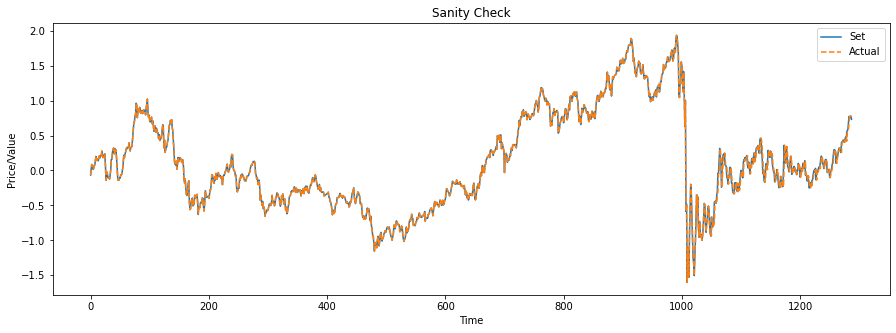

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1289 entries, 0 to 1288
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   close         1289 non-null   float32
 1   volume        1289 non-null   float32
 2   BBL_20_2.0    1289 non-null   float32
 3   BBM_20_2.0    1289 non-null   float32
 4   BBU_20_2.0    1289 non-null   float32
 5   BBB_20_2.0    1289 non-null   float32
 6   FWMA_200      1289 non-null   float32
 7   RSI_14        1289 non-null   float32
 8   MACD_8_32_9   1289 non-null   float32
 9   MACDh_8_32_9  1289 non-null   float32
 10  MACDs_8_32_9  1289 non-null   float32
 11  ADX_30        1289 non-null   float32
 12  DMP_30        1289 non-null   float32
 13  DMN_30        1289 non-null   float32
 14  AROOND_30     1289 non-null   float32
 15  AROONU_30     1289 non-null   float32
 16  AROONOSC_30   1289 non-null   float32
 17  SMA_200       1289 non-null   float32
dtypes: float32(18)
memory usage:

In [ ]:
# Fetch data from API
data = web.DataReader('O', data_source='yahoo', start='2015-06-01', end=datetime.today())
raw = data.copy()
data.columns = data.columns.str.lower()

# Feature engineer, adding Technical analysis indicators and dropping any NaN's
indicators = ta.Strategy(
    name="Common indicatiors",
    description="Bbands,",
    ta=[
        {"kind": "bbands", "length": 20},
        {"kind": "fwma", "length": 200},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 32, "signal": 9},
        {"kind": "adx", "length": 30},
        {"kind": "aroon", "length": 30},
        {"kind": "sma", "length": 200}
    ])
data.ta.strategy(indicators)
data.dropna(inplace=True)
data.info()
assert not np.any(data.index != raw.index[-data.shape[0]:]), "Indices doesn't match!"

data.drop(['open', 'high', 'low', 'adj close'], axis=1, inplace=True)

# Ensure that close is first column
col = data.pop('close')
data.insert(0, col.name, col)

# Scaling
scaler_close = RobustScaler()
#scaler_close = MinMaxScaler()
scaler_close.fit(data[['close']].astype('float32'))

scaler_ds = RobustScaler()
#scaler_ds = MinMaxScaler()
data = pd.DataFrame(scaler_ds.fit_transform(data.astype('float32')), columns=data.columns)#, index=data.index)

# Split data set
window_back = 90
window_forecast = 30

train_set, val_set, test_set = Split_data(data, window_back, window_forecast, format='tfds')
Sanity_check(data,(train_set,val_set,test_set),format='tfds')


# Optimize Hyperparameters
Use tuner to find the optimal hyperparameters defined in the model function

In [ ]:
# Ensure the same start each time
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Training Parameters
EPOCHS = 100
BATCH_SIZE = 32
input_shape = (window_back, data.shape[1])
n_out = window_forecast
optimizer = input("Proceed? y/n")
if optimizer == 'y':
  # Clear previous folder and iniate fresh callbacks
  %rm -rf New_model
  early_stopping = EarlyStopping(monitor='val_loss', 
                                 min_delta=5e-4, 
                                 patience=10, 
                                 verbose=1)
  
  dynamic_lr = ReduceLROnPlateau(monitor='val_RMSE', 
                                 min_delta=1e-3, 
                                 patience=5, 
                                 factor=0.5, 
                                 min_lr=1e-6,                                          
                                 verbose=1)
  class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
      IPython.display.clear_output(wait = True)

  tuner = kt.Hyperband(Model_1,
                     objective='val_loss',
                     max_epochs=EPOCHS,
                     factor=3,
                     overwrite=True,
                     project_name='New_model'
                     )
  #tuner.search_space_summary()
  start = time.time()

  tuner.search(train_set,
                batch_size=BATCH_SIZE, 
                epochs=EPOCHS,
                validation_data=val_set,
                verbose=2,
                shuffle=False,
               callbacks=[early_stopping, ClearTrainingOutput()])
  end = time.time()
  tunerTime = end - start

  tuner.results_summary(num_trials=1) 
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  #ds['values'] = best_hps.get_config()

Trial 16 Complete [00h 00m 03s]
val_loss: 3.7618908882141113

Best val_loss So Far: 0.5484812259674072
Total elapsed time: 00h 01m 18s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./New_model
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 4
tuner/round: 0
Score: 0.5484812259674072


#Train the model

USING OPTIMIZED
Epoch 1/200
30/30 - 2s - loss: 0.8532 - RMSE: 0.8074 - val_loss: 0.6006 - val_RMSE: 0.2331
Epoch 2/200
30/30 - 0s - loss: 0.7604 - RMSE: 0.7469 - val_loss: 0.5355 - val_RMSE: 0.2319
Epoch 3/200
30/30 - 0s - loss: 0.6733 - RMSE: 0.6953 - val_loss: 0.4814 - val_RMSE: 0.2469
Epoch 4/200
30/30 - 0s - loss: 0.5960 - RMSE: 0.6469 - val_loss: 0.4381 - val_RMSE: 0.2754
Epoch 5/200
30/30 - 0s - loss: 0.5257 - RMSE: 0.5976 - val_loss: 0.4052 - val_RMSE: 0.3149
Epoch 6/200
30/30 - 0s - loss: 0.4624 - RMSE: 0.5492 - val_loss: 0.3813 - val_RMSE: 0.3606
Epoch 7/200
30/30 - 0s - loss: 0.4066 - RMSE: 0.5053 - val_loss: 0.3643 - val_RMSE: 0.4068
Epoch 8/200
30/30 - 0s - loss: 0.3587 - RMSE: 0.4690 - val_loss: 0.3500 - val_RMSE: 0.4463
Epoch 9/200
30/30 - 0s - loss: 0.3181 - RMSE: 0.4414 - val_loss: 0.3348 - val_RMSE: 0.4732
Epoch 10/200
30/30 - 0s - loss: 0.2837 - RMSE: 0.4214 - val_loss: 0.3162 - val_RMSE: 0.4856
Epoch 11/200
30/30 - 0s - loss: 0.2546 - RMSE: 0.4073 - val_loss: 0.2943 

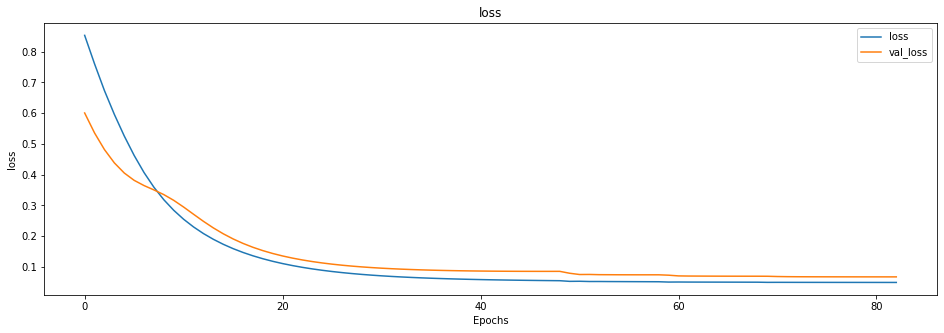

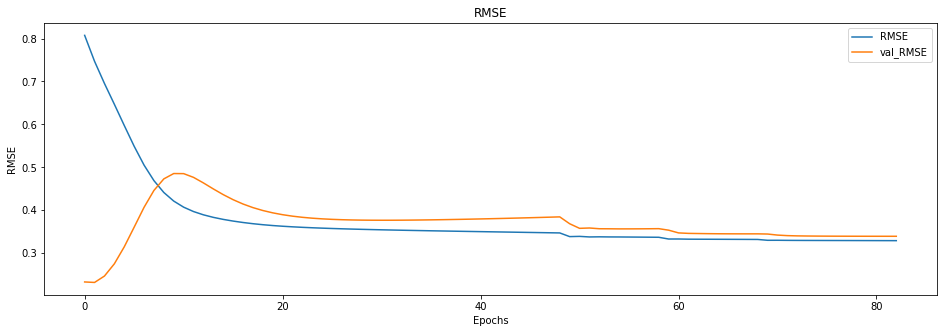

In [ ]:
# Ensure the same start each time
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
EPOCHS = 200
BATCH_SIZE = 32
try:
  tuner
except:
  print('USING DUMMY')
  input_shape = (window_back, data.shape[1])
  n_out = window_forecast
  model = Model_1(hp='dummy')
else:
  print('USING OPTIMIZED')
  model = tuner.hypermodel.build(best_hps)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=5e-4, 
                               patience=10, 
                               verbose=1)

model_checkpoint = ModelCheckpoint("model_checkpoint", 
                                   monitor='val_loss', 
                                   save_best_only=True)

lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20),
                                    verbose=1)

dynamic_lr = ReduceLROnPlateau(monitor='val_loss', 
                               min_delta=3e-3, 
                               patience=7, 
                               cooldown=4,
                               factor=0.5,                                          
                               min_lr=1e-6,
                               verbose=1)

# Start training
start = time.time()
result = model.fit(train_set,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_data=val_set,
                   verbose=2,
                   shuffle=False,
                   callbacks=[early_stopping, dynamic_lr])
end = time.time()
trainTime = end - start

Train_results(result)

#Predict

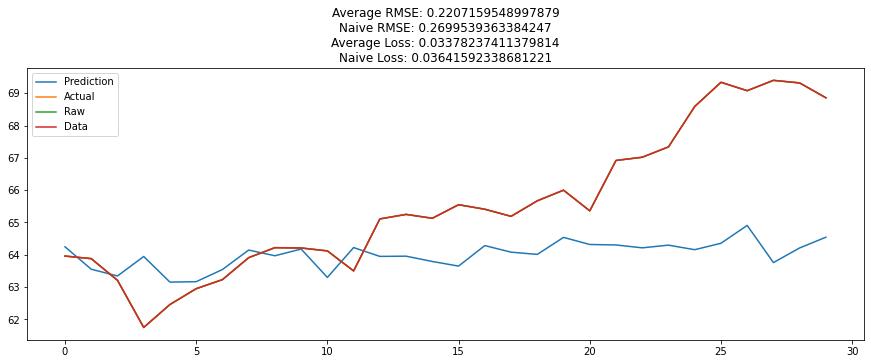

In [ ]:
prediction = model.predict(test_set)
prediction = np.reshape(prediction[0],(-1,1))

eva = model.evaluate(test_set, verbose=0)

actual = list(test_set.as_numpy_iterator())[0][1]
actual = actual.reshape(-1, 1)

# Naive forecast as a baseline metric
naive = np.array(data['close'].iloc[(-window_forecast-1):-1])
naive_error = naive - actual
naive_mae = np.mean(np.abs(naive_error))
naive_huber = np.mean(tf.keras.losses.huber(actual, naive, delta=d_huber))
naive_rmse = np.sqrt((naive_error**2).mean())

plt.figure(figsize=(15,5))
plt.plot(scaler_close.inverse_transform(prediction), label='Prediction')
plt.plot(scaler_close.inverse_transform(actual), label='Actual')
plt.plot(np.array(raw['Close'].iloc[-window_forecast:]), label='Raw')
plt.plot(np.array(scaler_close.inverse_transform(np.reshape(np.array(data['close'].iloc[-window_forecast:]),(-1,1)))), label='Data')
plt.legend()
if not np.isscalar(eva):
  plt.title('Average RMSE: {}\nNaive RMSE: {}\nAverage Loss: {}\nNaive Loss: {}'.format(eva[1], naive_rmse, eva[0], naive_huber))
else:
  plt.title('Average Loss: {}\nNaive RMSE: {}'.format(eva, naive_rmse))

#Save Models
Save both the trained model and a clean model using optimized hyperparameters. 

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
import os
mdl_path = '/content/drive/My Drive/Colab Notebooks/Models'
os.chdir(mdl_path)

info = model.get_config()
mdl = info['name']
if os.path.isdir('{}/{}'.format(mdl_path,mdl)):
  #print('FOLDER FOUND')
  os.chdir(mdl)
else:
  #print('CREATE FOLDER')
  os.mkdir(mdl)
  os.chdir(mdl)

date = datetime.today()
today = date.strftime('%Y-%m-%d')

mdl_name = '{}_{}_{}'.format(mdl,'Trained',today)
model.save(mdl_name, overwrite=False)

clean_mdl = tuner.hypermodel.build(best_hps)
clean_name = '{}_{}_{}'.format(mdl,'Clean',today)
clean_mdl.save(clean_name, overwrite=False)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: TEST_Trained_2020-10-10/assets
INFO:tensorflow:Assets written to: TEST_Clean_2020-10-10/assets


In [ ]:
#%pip install reportlab
#from reportlab.pdfgen.canvas import Canvas
#from reportlab.lib.pagesizes import A4
#from reportlab.lib.units import inch, cm
#from reportlab.platypus import Table, PageBreak


canvas = Canvas('Report_{}_{}.pdf'.format(mdl,today), pagesize=A4) 
canvas.setFont("Times-Roman", 28)
canvas.drawCentredString(297.5, 800, mdl)
canvas.setFont("Helvetica-Bold", 14)
canvas.drawString(20, 750, 'Hyperparameter-Tuner result:')

canvas.setFont("Helvetica-Bold", 12)
canvas.drawString(35,730,'Elapsed time: {}'.format(TimeConverter(tunerTime)))

canvas.setFont("Helvetica", 12)
hypvals = best_hps.get_config()
maxChar = len(max(list(hypvals['values'].keys()), key=len))
hypvals = hypvals['values']
texthyper = canvas.beginText(35, 710)
for i in range(len(hypvals)):
  texthyper.textLine('{}:'.format(list(hypvals.keys())[i]))
canvas.drawText(texthyper)
texthyper = canvas.beginText(35+130,710)
for i in range(len(hypvals)):
  texthyper.textLine('{}'.format(list(hypvals.values())[i]))
canvas.drawText(texthyper)



canvas.setFont("Helvetica-Bold", 14)
canvas.drawString(20, 710-(12*len(hypvals)+24), 'Model Architecture:')
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)

canvas.setFont("Helvetica", 12)
textobject = canvas.beginText(35, 710-(12*len(hypvals)+45))
for line in short_model_summary.splitlines(False):
    textobject.textLine(line.rstrip())
canvas.drawText(textobject)

# New page for training results
canvas.showPage()

#canvas.drawString(30,750-6-12*1,'Epochs: {} of {}'.format(len(result.epoch),EPOCHS))

canvas.save()

AttributeError: ignored

In [ ]:
ss = best_hps.get_config()
ss['values'].keys()
ss = ss['values']
res = len(max(list(ss.keys()), key=len))
print(res)

ds = '{msg: <{width}}lala'.format(msg='text',width=maxChar)
dss = '{msg: <{width}}lala'.format(msg='textthat is longer',width=maxChar)
print(ds)
print(dss)

19
text               lala
textthat is longer lala
